In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Bidirectional
from keras.utils.np_utils import to_categorical
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
import joblib

import time
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [2]:
data_normal_1 = pd.read_csv('dataset/timeseries/icmp_dataset_timeseries_normal_1.csv')
data_normal_2 = pd.read_csv('dataset/timeseries/icmp_dataset_timeseries_normal_2.csv')

data_normal_3 = pd.read_csv('dataset/timeseries/old/dataset_icmp_timeseries_normal.csv')

data_attack_1 = pd.read_csv('dataset/timeseries/icmp_dataset_timeseries_attack_1.csv')
data_attack_2 = pd.read_csv('dataset/timeseries/icmp_dataset_timeseries_attack_2.csv')

data_attack_3 = pd.read_csv('dataset/timeseries/old/dataset_icmp_timeseries_attack.csv')

In [3]:
data_normal_1.columns = ['chksum', 'id', 'seq', 'payload_len', 'label']
data_normal_2.columns = ['chksum', 'id', 'seq', 'payload_len', 'label']

data_normal_3.columns = ['timestamp', 'chksum', 'id', 'seq', 'payload_len', 'label']

data_attack_1.columns = ['chksum', 'id', 'seq', 'payload_len', 'label']
data_attack_2.columns = ['chksum', 'id', 'seq', 'payload_len', 'label']

data_attack_3.columns = ['timestamp', 'chksum', 'id', 'seq', 'payload_len', 'label']

In [4]:
data_normal_3 = data_normal_3.drop(['timestamp'],axis=1)

data_attack_3 = data_attack_3.drop(['timestamp'],axis=1)

In [5]:
features = ['chksum', 'id', 'seq', 'payload_len']

In [6]:
X_normal_1 = data_normal_1[features].values
X_normal_2 = data_normal_2[features].values
X_normal_3 = data_normal_3[features].values

X_attack_1 = data_attack_1[features].values
X_attack_2 = data_attack_2[features].values
X_attack_3 = data_attack_3[features].values

Y_normal_1 = data_normal_1['label']
Y_normal_2 = data_normal_2['label']
Y_normal_3 = data_normal_3['label']

Y_attack_1 = data_attack_1['label']
Y_attack_2 = data_attack_2['label']
Y_attack_3 = data_attack_3['label']

X=np.concatenate((X_normal_1,X_normal_2,X_normal_3,X_attack_1,X_attack_2,X_attack_3))
Y=np.concatenate((Y_normal_1,Y_normal_2,Y_normal_3,Y_attack_1,Y_attack_2,Y_attack_3))

In [7]:
scalar = StandardScaler(copy=True, with_mean=True, with_std=True)
scalar.fit(X)
X = scalar.transform(X)

In [8]:
print(np.shape(X))
print(np.shape(Y))

(70975, 4)
(70975,)


In [9]:
features = len(X[0])
samples = X.shape[0]
train_len = 200
input_len = samples - train_len
I = np.zeros((samples - train_len, train_len, features))

In [10]:
for i in range(input_len):
    temp = np.zeros((train_len, features))
    for j in range(i, i + train_len - 1):
        temp[j-i] = X[j]
    I[i] = temp

In [11]:
print(I.shape)

(70775, 200, 4)


In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(I, Y[200:], test_size = 0.2, stratify=Y[200:], random_state = 0)

In [13]:
def create_baseline():
    model = Sequential()
    model.add(Bidirectional(LSTM(64, activation='tanh', kernel_regularizer='l2')))
    model.add(Dense(128, activation = 'relu', kernel_regularizer='l2'))
    model.add(Dense(1, activation = 'sigmoid', kernel_regularizer='l2'))
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model

In [14]:
model = create_baseline()

In [15]:
checkpoint = ModelCheckpoint("LSTMmodel.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')

In [16]:
history = model.fit(X_train, Y_train, epochs = 30,validation_split=0.2, verbose = 1, callbacks=[checkpoint,early])

Epoch 1/30
1414/1416 [============================>.] - ETA: 0s - loss: 0.2215 - accuracy: 0.9488 ETA: 0s - loss: 0.2216 - accuracy: 0.94
Epoch 00001: val_loss improved from inf to 0.15408, saving model to LSTMmodel.h5
1416/1416 [==============================] - 44s 29ms/step - loss: 0.2214 - accuracy: 0.9488 - val_loss: 0.1541 - val_accuracy: 0.9255
Epoch 2/30
1416/1416 [==============================] - ETA: 0s - loss: 0.1199 - accuracy: 0.9744 ETA: 0s - loss: 0.1207 - ac
Epoch 00002: val_loss improved from 0.15408 to 0.04382, saving model to LSTMmodel.h5
1416/1416 [==============================] - 40s 28ms/step - loss: 0.1199 - accuracy: 0.9744 - val_loss: 0.0438 - val_accuracy: 0.9984
Epoch 3/30
1415/1416 [============================>.] - ETA: 0s - loss: 0.0439 - accuracy: 0.9976
Epoch 00003: val_loss improved from 0.04382 to 0.03657, saving model to LSTMmodel.h5
1416/1416 [==============================] - 39s 28ms/step - loss: 0.0439 - accuracy: 0.9976 - val_loss: 0.0366 - val

1415/1416 [============================>.] - ETA: 0s - loss: 0.0237 - accuracy: 0.9991
Epoch 00028: val_loss improved from 0.02040 to 0.02036, saving model to LSTMmodel.h5
1416/1416 [==============================] - 40s 28ms/step - loss: 0.0237 - accuracy: 0.9991 - val_loss: 0.0204 - val_accuracy: 0.9999
Epoch 29/30
1414/1416 [============================>.] - ETA: 0s - loss: 0.0396 - accuracy: 0.9962
Epoch 00029: val_loss did not improve from 0.02036
1416/1416 [==============================] - 39s 28ms/step - loss: 0.0396 - accuracy: 0.9962 - val_loss: 0.0259 - val_accuracy: 0.9990
Epoch 30/30
1416/1416 [==============================] - ETA: 0s - loss: 0.0257 - accuracy: 0.9991
Epoch 00030: val_loss did not improve from 0.02036
1416/1416 [==============================] - 39s 28ms/step - loss: 0.0257 - accuracy: 0.9991 - val_loss: 0.0215 - val_accuracy: 0.9999


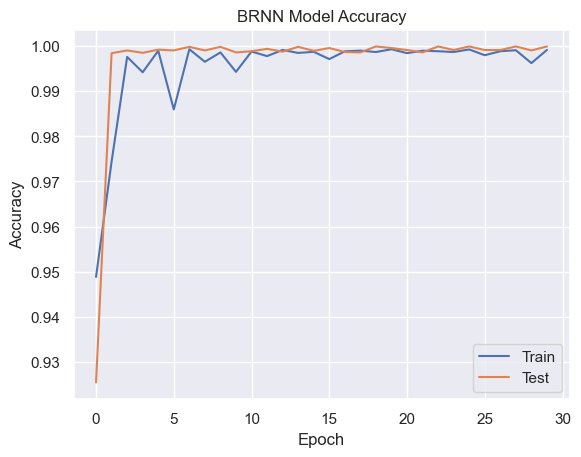

In [17]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('BRNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.savefig('BRNN 200 Model Accuracy.png')
plt.show()

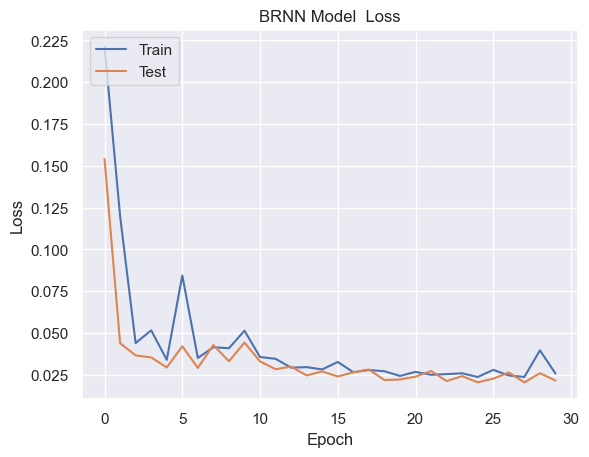

In [18]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('BRNN Model  Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('BRNN 200 Model Loss.png')
plt.show()

In [19]:
predict = model.predict(X_test, verbose=1)

443/443 [==============================] - 6s 13ms/step


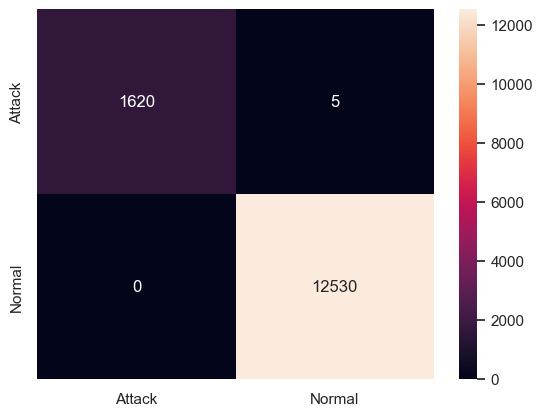

In [20]:
tp = 0
tn = 0
fp = 0
fn = 0
predictn = predict.flatten().round()
predictn = predictn.tolist()
Y_testn = Y_test.tolist()
for i in range(len(Y_testn)):
  if predictn[i]==1 and Y_testn[i]==1:
    tp+=1
  elif predictn[i]==0 and Y_testn[i]==0:
    tn+=1
  elif predictn[i]==0 and Y_testn[i]==1:
    fp+=1
  elif predictn[i]==1 and Y_testn[i]==0:
    fn+=1
to_heat_map =[[tn,fp],[fn,tp]]
to_heat_map = pd.DataFrame(to_heat_map, index = ["Attack","Normal"],columns = ["Attack","Normal"])
ax = sns.heatmap(to_heat_map,annot=True, fmt="d")

In [21]:
figure = ax.get_figure()
figure.savefig('confusion_matrix_BRNN_200.png', dpi=400)

In [22]:
# model.save('brnn_model_200_step.h5')
joblib.dump(scalar, 'scaler_200.save')

['scaler_200.save']

In [23]:
scores = model.evaluate(X_test, Y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

accuracy: 99.96%


In [24]:
print(classification_report(Y_testn,predictn))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1620
           1       1.00      1.00      1.00     12535

    accuracy                           1.00     14155
   macro avg       1.00      1.00      1.00     14155
weighted avg       1.00      1.00      1.00     14155



In [25]:
lr_auc = roc_auc_score(Y_testn, predictn)
print('SVM: ROC AUC=%.3f' % (lr_auc))

SVM: ROC AUC=1.000


In [26]:
time_start = time.perf_counter()
predict = model.predict(I[:200], verbose=1)
print(f"Time elapse for prediction : {time.perf_counter() - time_start}")
print(predict)

7/7 [==============================] - 0s 12ms/step
Time elapse for prediction : 0.12326950000010584
[[0.01324232]
 [0.01309435]
 [0.01297562]
 [0.01302463]
 [0.01326269]
 [0.01309529]
 [0.01320049]
 [0.01340138]
 [0.01346613]
 [0.01350144]
 [0.01348446]
 [0.01336896]
 [0.01340148]
 [0.01321684]
 [0.01308173]
 [0.01293032]
 [0.01288727]
 [0.01311849]
 [0.01300961]
 [0.01302167]
 [0.01323348]
 [0.01303129]
 [0.01281878]
 [0.01279098]
 [0.01311436]
 [0.01313001]
 [0.01289153]
 [0.01287569]
 [0.01288493]
 [0.01306103]
 [0.01332429]
 [0.0134155 ]
 [0.01343907]
 [0.01344704]
 [0.0134515 ]
 [0.01344884]
 [0.01345289]
 [0.01331528]
 [0.01313845]
 [0.013014  ]
 [0.01335345]
 [0.01336496]
 [0.01339064]
 [0.01337217]
 [0.01342632]
 [0.01340069]
 [0.01330384]
 [0.01309845]
 [0.01301795]
 [0.01312771]
 [0.01321906]
 [0.01343572]
 [0.01339733]
 [0.0131666 ]
 [0.0130386 ]
 [0.01283733]
 [0.01288836]
 [0.01326381]
 [0.01312644]
 [0.01309531]
 [0.01319861]
 [0.01331903]
 [0.01336967]
 [0.01329232]
 [0